In [72]:
import requests
import pandas as pd
import numpy as np
import time

In [73]:
from credentials import fred_api_key

In [74]:
api_key = fred_api_key

In [75]:
def fred(series_id, api_key, date_list):
    """
    Retrieve economic data from the Federal Reserve Economic Data (FRED) API and return it as a DataFrame.

    Parameters:
        series_id (str): The unique identifier of the economic series on FRED.
        api_key (str): Your personal API key to access FRED API. Get it from https://fred.stlouisfed.org/.
        date_list (list): A list of tuples containing start and end dates for data retrieval. 
                          Each tuple should be in the format ('YYYY-MM-DD', 'YYYY-MM-DD').

    Returns:
        pandas.DataFrame: A DataFrame containing the retrieved economic data, indexed by date.

    Raises:
        ValueError: If the API response status code is not 200.
    """
    
    data_frames = []  # List to store individual DataFrames
    for start_date, end_date in date_list:
        params = {
            'series_id': series_id,
            'api_key': api_key,
            'file_type': 'json',
            'limit': 2000,
            'observation_start': start_date,
            'observation_end': end_date
        }
        
        endpoint = 'https://api.stlouisfed.org/fred/series/observations'
        response = requests.get(endpoint, params=params)

        if response.status_code == 200:
            data = response.json()
            # Process the data as needed (you can uncomment the print statement for debugging)
            # print(data)
        else:
            raise ValueError(f"Error: {response.status_code} - {response.text}")
            
        df = pd.DataFrame(data['observations'])
        data_frames.append(df)
        
    if data_frames:
        data = pd.concat(data_frames, axis=0, ignore_index=True)
    else:
        data = pd.DataFrame()
        
    data.drop(columns=['realtime_start', 'realtime_end'], inplace=True)
    data['date'] = pd.to_datetime(data['date'])

    data['value'] = pd.to_numeric(data['value'], errors='coerce')
    data.set_index('date', inplace=True)
    data.rename(columns={'value': f'{series_id}'}, inplace=True)

    return data


In [76]:
# For many of the data series FRED has a daily limit of 2000 rows. Therefore, I split the data into ranges below so that
# collect all the data from a series.
date_list = [
    ('1993-01-01', '1998-12-31'), ('1999-01-01', '2004-12-31'),
    ('2005-01-01', '2010-12-31'), ('2011-01-01', '2016-12-31'),
    ('2017-01-01', '2022-12-31'), ('2023-01-01', '2029-12-31'),
] 

In [77]:
start_time = time.time()

series_id_list = ['DFF', 'UNRATE', 'MEDCPIM158SFRBCLE', 'MRTSSM44X72USS', 'IRLTLT01USM156N', 
                  'T10Y3M', 'VIXCLS', 'DEXCHUS', 'DEXJPUS']
variable_names = ['ffr', 'unemployment_rate', 'median_cpi', 'retail_sales', '10_year_treasury_yeild', 
                  '10year_3month_yield_spread', 'vix', 'us_china_exchange_rate', 'us_japan_exchange_rate']

df_list = [fred(series_id, api_key, date_list) for series_id in series_id_list]

economic_data = pd.concat(df_list, axis=1)
economic_data.rename(columns={k:v for k,v in zip(series_id_list, variable_names)}, inplace=True)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 15.545575857162476 seconds


In [78]:
economic_data.head(3)

,ffr,unemployment_rate,median_cpi,retail_sales,10_year_treasury_yeild,10year_3month_yield_spread,vix,us_china_exchange_rate,us_japan_exchange_rate
date,,,,,,,,,
1993-01-01,2.66,7.3,3.442924,175108.0,6.6,NaN,NaN,NaN,NaN
1993-01-02,2.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-01-03,2.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
gdp = fred('GDPC1', api_key, date_list)
gdp.head()

,GDPC1
date,
1993-01-01,9857.185
1993-04-01,9914.565
1993-07-01,9961.873
1993-10-01,10097.362
1994-01-01,10195.338


In [80]:
gdp['lag'] = gdp['GDPC1'].shift()
gdp['growth'] = (gdp['GDPC1'] - gdp['lag'])/gdp['lag']*100
gdp.head()

,GDPC1,lag,growth
date,,,
1993-01-01,9857.185,NaN,NaN
1993-04-01,9914.565,9857.185,0.582113
1993-07-01,9961.873,9914.565,0.477157
1993-10-01,10097.362,9961.873,1.360076
1994-01-01,10195.338,10097.362,0.970313


<Axes: xlabel='date'>

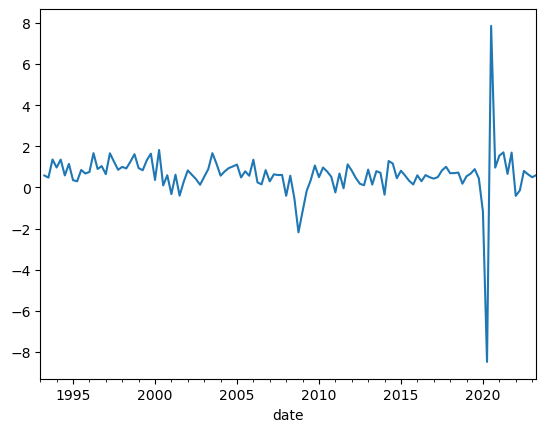

In [81]:
gdp['growth'].plot()

In [82]:
cpi = fred('CPIAUCSL', api_key, date_list)
cpi['lag'] = cpi['CPIAUCSL'].shift()
cpi['inflation'] = (cpi['CPIAUCSL'] - cpi['lag'])/cpi['lag']*100

cpi.head()

,CPIAUCSL,lag,inflation
date,,,
1993-01-01,142.8,NaN,NaN
1993-02-01,143.1,142.8,0.210084
1993-03-01,143.3,143.1,0.139762
1993-04-01,143.8,143.3,0.348918
1993-05-01,144.2,143.8,0.278164


<Axes: xlabel='date'>

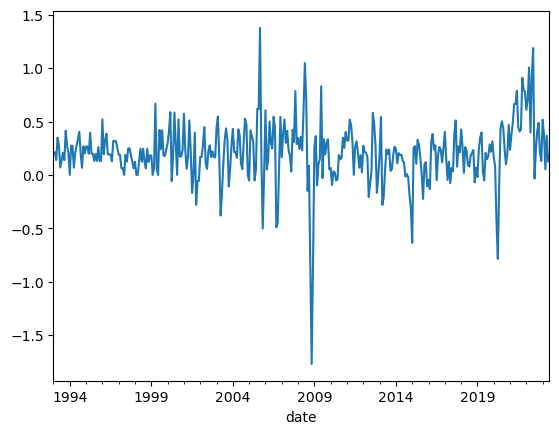

In [83]:
cpi['inflation'].plot()

In [84]:
economic_data = pd.concat([economic_data, cpi['inflation'], gdp['growth']], axis=1)

In [85]:
economic_data.to_pickle('../data/fred.pkl')